# Topic Modeling wiht Latent Semantic Analysis

Latent Semantic Analysis (LSA) is a method for finding latent similarities between documents treated as a bag of words by using a low rank approximation. It is used for document classification, clustering and retrieval. For example, LSA can be used to search for prior art given a new patent application. In this homework, we will implement a small library for simple latent semantic analysis as a practical example of the application of SVD. The ideas are very similar to PCA. SVD is also used in recommender systems in an similar fashion (for an SVD-based recommender system library, see [Surpise](http://surpriselib.com). 

We will implement a toy example of LSA to get familiar with the ideas. If you want to use LSA or similar methods for statistical language analysis, the most efficient Python libraries are probably [gensim](https://radimrehurek.com/gensim/) and [spaCy](https://spacy.io) - these also provide an online algorithm - i.e. the training information can be continuously updated. Other useful functions for processing natural language can be found in the [Natural Language Toolkit](http://www.nltk.org/).

**Note**: The SVD from scipy.linalg performs a full decomposition, which is inefficient since we only need to decompose until we get the first k singluar values. If the SVD from `scipy.linalg` is too slow, please use the `sparsesvd` function from the [sparsesvd](https://pypi.python.org/pypi/sparsesvd/) package to perform SVD instead.  You can install in the usual way with 
```
!pip install sparsesvd
```

Then import the following
```python
from sparsesvd import sparsesvd 
from scipy.sparse import csc_matrix 
```

and use as follows
```python
sparsesvd(csc_matrix(M), k=10)
```

**Exercise 1 (20 points)**.  Calculating pairwise distance matrices.

Suppose we want to construct a distance matrix between the rows of a matrix. For example, given the matrix 

```python
M = np.array([[1,2,3],[4,5,6]])
```

the distance matrix using Euclidean distance as the measure would be
```python
[[ 0.000  1.414  2.828]
 [ 1.414  0.000  1.414]
 [ 2.828  1.414  0.000]] 
```
if $M$ was a collection of column vectors.

Write a function to calculate the pairwise-distance matrix given the matrix $M$ and some arbitrary distance function. Your functions should have the following signature:
```
def func_name(M, distance_func):
    pass
```

0. Write a distance function for the Euclidean, squared Euclidean and cosine measures.
1. Write the function using looping for M as a collection of row vectors.
2. Write the function using looping for M as a collection of column vectors.
3. Wrtie the function using broadcasting for M as a collection of row vectors.
4. Write the function using broadcasting for M as a collection of column vectors. 

For 3 and 4, try to avoid using transposition (but if you get stuck, there will be no penalty for using transposition). Check that all four functions give the same result when applied to the given matrix $M$.

In [1]:
import numpy as np
def Euclid_dist_sqr(x, y, vec='rowvec'):
    tmp = (x-y)**2
    if vec == 'rowvec':
        return np.sum(tmp, axis=-1)
    elif vec == 'colvec':
        return np.sum(tmp, axis=0)
    
def Euclid_dist(x, y, vec='rowvec'):
    return np.sqrt(Euclid_dist_sqr(x, y, vec))
    
def cosine_dist(x, y, vec='rowvec'):
    if vec == 'rowvec':
        dotprod = np.squeeze(x) @ np.squeeze(y).T
        denom = np.linalg.norm(x, axis=-1) * np.linalg.norm(y, axis=-1)
    elif vec == 'colvec':
        dotprod = np.squeeze(x).T @ np.squeeze(y)
        denom = np.linalg.norm(x, axis=0) * np.linalg.norm(y, axis=0)
    return dotprod/denom

def rowvec_dist_loop(M, dist_func):
    r_n, _ = M.shape
    dist_mat = np.zeros((r_n, r_n))
    for i in range(r_n):
        for j in range(i,r_n):
            dist_mat[i,j] = dist_mat[j,i] = dist_func(M[i,:], M[j,:])
    return dist_mat
    
def colvec_dist_loop(M, dist_func):
    _, c_n = M.shape
    dist_mat = np.zeros((c_n, c_n))
    for i in range(c_n):
        for j in range(i,c_n):
            dist_mat[i,j] = dist_mat[j,i] = dist_func(M[:,i], M[:,j])
    return dist_mat
        
def rowvec_dist_bc(M, dist_func):
    return dist_func(M[:,None], M[None,:], 'rowvec')
        
def colvec_dist_bc(M, dist_func):
    return dist_func(M[:,None], M[...,None], 'colvec')

# check for correctness
M = np.array([[1,2,3],[4,5,6]])
dist_table = {'Euclidean':Euclid_dist_sqr, 'Squared Euclidean':Euclid_dist, 'Cosine':cosine_dist}
for name,dict_f in dist_table.items():
    if ~np.any(rowvec_dist_loop(M, dict_f) - rowvec_dist_bc(M, dict_f)):
        print('same row vec dist checked for %s dist:\n'%name,rowvec_dist_bc(M, dict_f))
    if ~np.any(colvec_dist_loop(M, dict_f) - colvec_dist_bc(M, dict_f)):
        print('same col vec dist checked for %s dist:\n'%name, colvec_dist_bc(M, dict_f))

same row vec dist checked for Euclidean dist:
 [[ 0 27]
 [27  0]]
same col vec dist checked for Euclidean dist:
 [[0 2 8]
 [2 0 2]
 [8 2 0]]
same row vec dist checked for Squared Euclidean dist:
 [[ 0.          5.19615242]
 [ 5.19615242  0.        ]]
same col vec dist checked for Squared Euclidean dist:
 [[ 0.          1.41421356  2.82842712]
 [ 1.41421356  0.          1.41421356]
 [ 2.82842712  1.41421356  0.        ]]
same row vec dist checked for Cosine dist:
 [[ 1.          0.97463185]
 [ 0.97463185  1.        ]]
same col vec dist checked for Cosine dist:
 [[ 1.          0.99083017  0.97618706]
 [ 0.99083017  1.          0.99654576]
 [ 0.97618706  0.99654576  1.        ]]


**Exercise 2 (20 points)**. 

**Exercise 2 (20 points)**. Write 3 functions to calculate the term frequency (tf), the inverse document frequency (idf) and the product (tf-idf). Each function should take a single argument `docs`, which is a dictionary of (key=identifier, value=document text) pairs, and return an appropriately sized array. Convert '-' to ' ' (space), remove punctuation, convert text to lowercase and split on whitespace to generate a collection of terms from the document text.

- tf = the number of occurrences of term $i$ in document $j$
- idf = $\log \frac{n}{1 + \text{df}_i}$ where $n$ is the total number of documents and $\text{df}_i$ is the number of documents in which term $i$ occurs.

Print the table of tf-idf values for the following document collection

```
s1 = "The quick brown fox"
s2 = "Brown fox jumps over the jumps jumps jumps"
s3 = "The the the lazy dog elephant."
s4 = "The the the the the dog peacock lion tiger elephant"

docs = {'s1': s1, 's2': s2, 's3': s3, 's4': s4}
```

In [2]:
import toolz as tz
import toolz.curried as c
import string
import pandas as pd

def tf(docs):
    return tz.pipe(
        docs.values(),
        c.map(lambda x: x.strip()),
        c.map(lambda x: x.replace('-',' ')),
        c.map(lambda x: x.translate(str.maketrans(string.ascii_uppercase, string.ascii_lowercase, string.punctuation))),
        c.map(lambda x: x.split()),
        c.map(lambda x: tz.frequencies(x)),
        list
    )

def idf(docs):
    df = tz.pipe(
        tf(docs),
        c.mapcat(lambda x: x.keys()),
        tz.frequencies
    )
    n = len(docs)
    return {key:np.log(n/(1+val)) for key, val in df.items()}

def tf_idf(docs):
    docs_tf = tf(docs)
    docs_idf = idf(docs)
    terms = docs_idf.keys()
    return {name:{term:docs_tf[i].get(term,0)*docs_idf[term] for term in terms} for i,name in enumerate(docs)}
        

# test part
s1 = "The quick brown fox"
s2 = "Brown fox jumps over the jumps jumps jumps"
s3 = "The the the lazy dog elephant."
s4 = "The the the the the dog peacock lion tiger elephant"

docs = {'s1': s1, 's2': s2, 's3': s3, 's4': s4}
pd.DataFrame(tf_idf(docs))

,s1,s2,s3,s4
brown,0.287682,0.287682,0.000000,0.000000
dog,0.000000,0.000000,0.287682,0.287682
elephant,0.000000,0.000000,0.287682,0.287682
fox,0.287682,0.287682,0.000000,0.000000
jumps,0.000000,2.772589,0.000000,0.000000
lazy,0.000000,0.000000,0.693147,0.000000
lion,0.000000,0.000000,0.000000,0.693147
over,0.000000,0.693147,0.000000,0.000000
peacock,0.000000,0.000000,0.000000,0.693147
quick,0.693147,0.000000,0.000000,0.000000


**Exercise 3 (20 points)**. 

1. Write a function that takes a matrix $M$ and an integer $k$ as arguments, and reconstructs a reduced matrix using only the $k$ largest singular values. Use the `scipy.linagl.svd` function to perform the decomposition. This is the least squares approximation to the matrix $M$ in $k$ dimensions.

2. Apply the function you just wrote to the following term-frequency matrix for a set of $9$ documents using $k=2$ and print the reconstructed matrix $M'$.
```
M = np.array([[1, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 1, 0, 0, 0, 0],
       [0, 1, 1, 2, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1]])
```

3. Calculate the pairwise correlation matrix for the original matrix M and the reconstructed matrix using $k=2$ singular values (you may use [scipy.stats.spearmanr](http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html) to do the calculations). Consider the fist 5 sets of documents as one group $G1$ and the last 4 as another group $G2$ (i.e. first 5 and last 4 columns). What is the average within group correlation for $G1$, $G2$ and the average cross-group correlation for G1-G2 using either $M$ or $M'$. (Do not include self-correlation in the within-group calculations.).

In [3]:
import scipy.linalg as la
import scipy.stats as stats

def mat_rec(M, k):
    U,s,Vh = la.svd(M)
    return U[:,:k]@np.diag(s[:k])@Vh[:k,:]

M = np.array(
    [[1, 0, 0, 1, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 1, 0, 0, 0, 0],
    [0, 1, 1, 2, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 1, 0, 0, 0, 0],
    [0, 1, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 1, 1, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 1, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 1, 1]])

M_rec = mat_rec(M, 2)
print(M_rec)
M_spmr,_ = stats.spearmanr(M, axis=0)
M_rec_spmr,_ = stats.spearmanr(M_rec, axis=0)

n1,n2 = 5,4
G1_avg = (np.sum(M_spmr[:n1,:n1])-n1)/(n1**2-n1)
G2_avg = (np.sum(M_spmr[-n2:,-n2:])-n2)/(n2**2-n2)
cross_avg = np.sum(M_spmr[:n1,-n2:])/(n1*n2)
print('average within group correlation for G1 is', G1_avg)
print('average within group correlation for G2 is', G2_avg)
print('average cross group correlation is', cross_avg)

[[ 0.16205797  0.40049828  0.37895454  0.46756626  0.17595367 -0.05265495
  -0.11514284 -0.15910198 -0.09183827]
 [ 0.14058529  0.36980077  0.32899603  0.40042722  0.16497247 -0.03281545
  -0.07056857 -0.09676827 -0.04298073]
 [ 0.15244948  0.50500444  0.35793658  0.41010678  0.23623173  0.02421652
   0.05978051  0.0868573   0.12396632]
 [ 0.25804933  0.84112343  0.60571995  0.69735717  0.39231795  0.03311801
   0.08324491  0.12177239  0.18737973]
 [ 0.44878975  1.23436483  1.0508615   1.26579559  0.55633139 -0.07378998
  -0.15469383 -0.20959816 -0.04887954]
 [ 0.15955428  0.5816819   0.37521897  0.41689768  0.27654052  0.05590374
   0.1322185   0.18891146  0.21690761]
 [ 0.15955428  0.5816819   0.37521897  0.41689768  0.27654052  0.05590374
   0.1322185   0.18891146  0.21690761]
 [ 0.21846278  0.54958058  0.51096047  0.62805802  0.24253607 -0.06541098
  -0.14252146 -0.19661186 -0.1079133 ]
 [ 0.09690639  0.53206438  0.22991365  0.21175363  0.26652513  0.13675618
   0.31462078  0.44444

**Exercise 4 (40 points)**. Clustering with LSA

1. Begin by loading a PubMed database of selected article titles using 'cPickle'. With the following:
```import cPickle
docs = cPickle.load(open('pubmed.pic'))```

    Create a tf-idf matrix for every term that appears at least once in any of the documents. What is the shape of the tf-idf matrix? 

2. Perform SVD on the tf-idf matrix to obtain $U \Sigma V^T$ (often written as $T \Sigma D^T$ in this context with $T$ representing the terms and $D$ representing the documents). If we set all but the top $k$ singular values to 0, the reconstructed matrix is essentially $U_k \Sigma_k V_k^T$, where $U_k$ is $m \times k$, $\Sigma_k$ is $k \times k$ and $V_k^T$ is $k \times n$. Terms in this reduced space are represented by $U_k \Sigma_k$ and documents by $\Sigma_k V^T_k$. Reconstruct the matrix using the first $k=10$ singular values.

3. Use agglomerative hierarchical clustering with complete linkage to plot a dendrogram and comment on the likely number of  document clusters with $k = 100$. Use the dendrogram function from [SciPy ](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

4. Determine how similar each of the original documents is to the new document `mystery.txt`. Since $A = U \Sigma V^T$, we also have $V = A^T U S^{-1}$ using orthogonality and the rule for transposing matrix products. This suggests that in order to map the new document to the same concept space, first find the tf-idf vector $v$ for the new document - this must contain all (and only) the terms present in the existing tf-idx matrix. Then the query vector $q$ is given by $v^T U_k \Sigma_k^{-1}$. Find the 10 documents most similar to the new document and the 10 most dissimilar. 

Notes on the Pubmed articles
----

These were downloaded with the following script.

```python
from Bio import Entrez, Medline
Entrez.email = "YOUR EMAIL HERE"
import cPickle

try:
    docs = cPickle.load(open('pubmed.pic'))
except Exception, e:
    print e

    docs = {}
    for term in ['plasmodium', 'diabetes', 'asthma', 'cytometry']:
        handle = Entrez.esearch(db="pubmed", term=term, retmax=50)
        result = Entrez.read(handle)
        handle.close()
        idlist = result["IdList"]
        handle2 = Entrez.efetch(db="pubmed", id=idlist, rettype="medline", retmode="text")
        result2 = Medline.parse(handle2)
        for record in result2:
            title = record.get("TI", None)
            abstract = record.get("AB", None)
            if title is None or abstract is None:
                continue
            docs[title] = '\n'.join([title, abstract])
            print title
        handle2.close()
    cPickle.dump(docs, open('pubmed.pic', 'w'))
docs.values()
```

THe difference between reconstruct tfidf(k=10) and original: 846.619740336


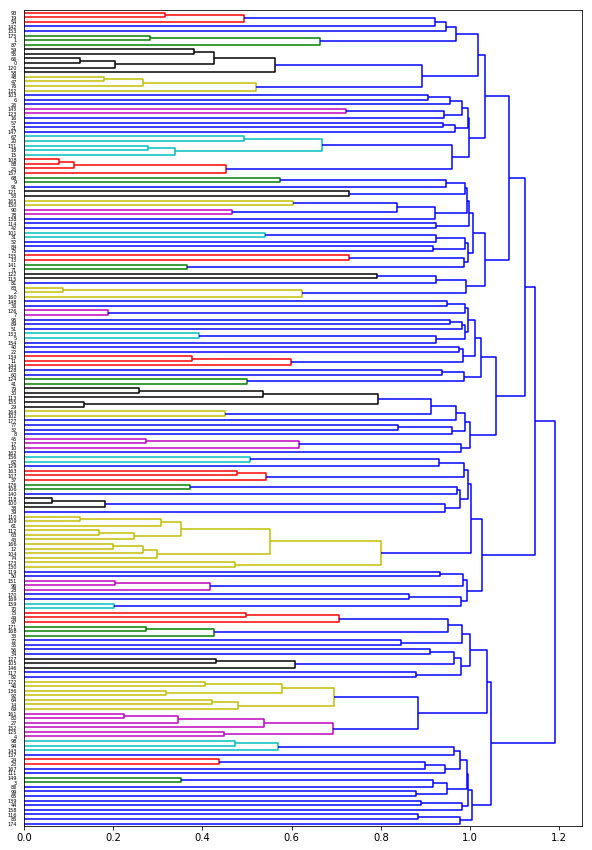

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
from sparsesvd import sparsesvd 
from scipy.sparse import csc_matrix
import scipy.cluster.hierarchy as hiera_clus
from scipy.spatial.distance import pdist,cdist

docs = pickle.load(open('data/pubmed.pic', 'rb'))
docs_tfidf = tf_idf(docs)
tfidf_mat = pd.DataFrame(docs_tfidf).values

T, sigma, Dh = sparsesvd(csc_matrix(tfidf_mat), k=10)
tfidf_rec = T.T @ np.diag(sigma) @ Dh
print('THe difference between reconstruct tfidf(k=10) and original:',la.norm(tfidf_rec-tfidf_mat))

"""perform agglomerative clustering based on tfidf reconstruction matrix(k=100)"""
T, sigma, Dh = sparsesvd(csc_matrix(tfidf_mat), k=100)
docs_feat = np.diag(sigma)@Dh # topic proportion features of each documents
dist_mat = pdist(docs_feat.T, metric='cosine')
link_mat = hiera_clus.linkage(dist_mat, method='complete')
plt.figure(figsize=(10,15))
plt.show(hiera_clus.dendrogram(link_mat, orientation='right'))
pass

Based on the agglomerative clustering result figure, an approriate number of cluster should be 4, where each cluster have similar size. In other words, based on the topic proportion representation, we cluster all documents into 4 categories.

In [5]:
from scipy.spatial.distance import cdist
newdoc = open('data/mystery.txt').read()
newdoc_tf = tf({'newdoc1':newdoc})[0]


docs_idf = idf(docs)
docs_terms = docs_idf.keys()

newdoc_tfidf = {'new_doc':{term:newdoc_tf.get(term,0)*docs_idf.get(term,0) for term in docs_terms}}
newdoc_tfidf = pd.DataFrame(newdoc_tfidf).values

T, sigma, Dh = sparsesvd(csc_matrix(tfidf_mat), k=100)
newdoc_feat = newdoc_tfidf.T @ T.T @ np.diag(1/sigma)
dist = cdist(newdoc_feat, Dh.T, metric='cosine')
sorted_idx = np.squeeze(np.argsort(dist))
topk_similar_idx = sorted_idx[:10]
topk_dissimilar_idx = sorted_idx[-10:]
titles = pd.DataFrame(docs_tfidf).columns.values
print('The top 10 most similar documents titles are:\n', titles[topk_similar_idx])
print('\n')
print('The top 10 most dissimilar documents titles are:\n', titles[topk_dissimilar_idx])

The top 10 most similar documents titles are:
 [ 'Diabetes Numeracy and Blood Glucose Control: Association With Type of Diabetes and Source of Care.'
 'Feasibility of the SMART Project: A Text Message Program for Adolescents With Type 1 Diabetes.'
 'Health Care Utilization Among U.S. Adults With Diagnosed Diabetes, 2013.'
 'Outcomes of a Diabetes Education Program for Registered Nurses Caring for Individuals With Diabetes.'
 'Effect of Self-Efficacy on Weight Loss: A Psychosocial Analysis of a Community-Based Adaptation of the Diabetes Prevention Program Lifestyle Intervention.'
 '"Living Well with Diabetes": Evaluation of a Pilot Program to Promote Diabetes Prevention and Self-Management in a Medically Underserved Community.'
 'Efficacy and Safety of Saxagliptin as Add-On Therapy in Type 2 Diabetes.'
 'Disparities in Postpartum Follow-Up in Women With Gestational Diabetes Mellitus.'
 'Demographic Disparities Among Medicare Beneficiaries with Type 2 Diabetes Mellitus in 2011: Diabetes 